In [15]:
!pip install scikit-surprise
!pip install fuzzywuzzy
!pip install rapidfuzz

In [16]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from surprise import Reader, Dataset, KNNBasic, accuracy

In [17]:
# Loading the datasets
movies = pd.read_csv('/content/drive/MyDrive/dataset/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/dataset/ratings.csv')

movies["new_movieId"] = range(1, movies["movieId"].nunique() + 1)


ratings = ratings.merge(movies[["movieId", "new_movieId"]], how="left", on="movieId")
ratings["movieId"] = ratings["new_movieId"]
movies["movieId"] = movies["new_movieId"]

# Dropping the new_movieId column
ratings.drop(["new_movieId"], axis=1, inplace=True)
movies.drop(["new_movieId"], axis=1, inplace=True)



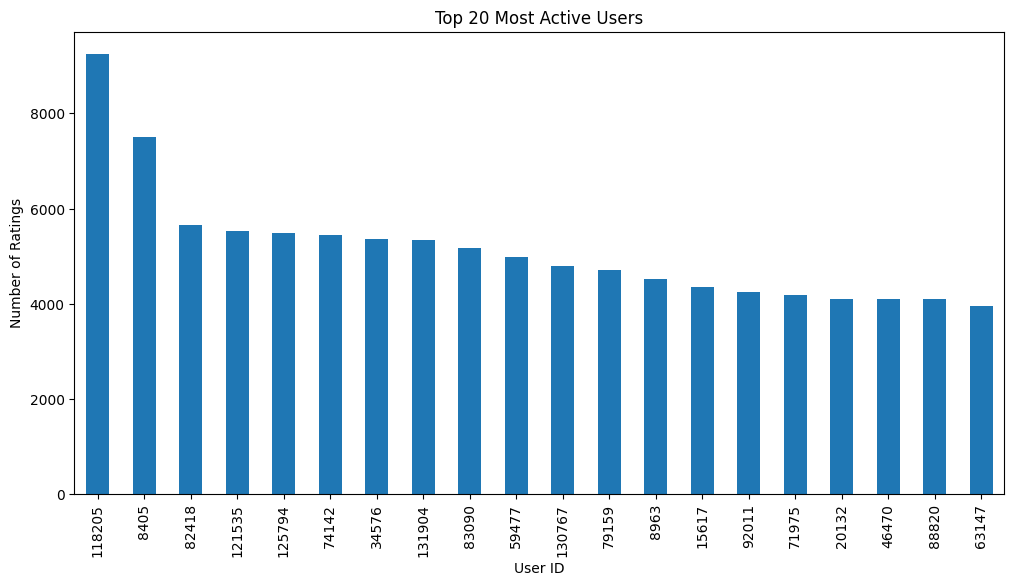

In [18]:
# Top 20 Most Active Users
user_activity = ratings['userId'].value_counts().head(20)
user_activity.plot(kind='bar', figsize=(12, 6), title="Top 20 Most Active Users")
plt.xlabel("User ID")
plt.ylabel("Number of Ratings")
plt.show()

In [19]:
print(ratings.info())
print(ratings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB
None
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580


In [20]:
ratings = ratings.sample(frac=0.001, random_state=42)

In [21]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 17679788 to 11007120
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     20000 non-null  int64  
 1   movieId    20000 non-null  int64  
 2   rating     20000 non-null  float64
 3   timestamp  20000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 781.2 KB


In [22]:
# Preparing the data
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Building the trainset
trainset = data.build_full_trainset()

# Using KNNBasic algorithm for User-User Collaborative Filtering
sim_options = {
    'name': 'cosine',
    'user_based': True  # Compute similarities between users
}

algo = KNNBasic(sim_options=sim_options)

# Training the algorithm on the trainset
algo.fit(trainset)



Computing the cosine similarity matrix...
Done computing similarity matrix.


In [23]:

def  User_UserSimilarity(user_id, num_recommendations=5):
    # Get a list of all movie ids
    all_movie_ids = set(ratings['movieId'].unique())
    # Get the movies that the user has already rated
    rated_movie_ids = set(ratings[ratings['userId'] == user_id]['movieId'])
    # Movies to predict
    movies_to_predict = list(all_movie_ids - rated_movie_ids)

    # Predict ratings for the movies the user hasn't rated yet
    predictions = []
    for movie_id in movies_to_predict:
        pred = algo.predict(user_id, movie_id, verbose=False)
        predictions.append((movie_id, pred.est))

    # Sort the predictions based on estimated rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_predictions = predictions[:num_recommendations]


    top_movie_ids = [pred[0] for pred in top_predictions]
    recommended_movies = movies[movies["movieId"].isin(top_movie_ids)][["movieId", "title", "genres"]]

    # Add the estimated ratings to the dataframe
    estimated_ratings = [pred[1] for pred in top_predictions]
    recommended_movies['estimated_rating'] = estimated_ratings

    # Sort by estimated rating
    recommended_movies = recommended_movies.sort_values(by='estimated_rating', ascending=False)
    recommended_movies.reset_index(drop=True, inplace=True)

    return recommended_movies

In [24]:
user_id = 10
num_recommendations = 5  # Number of movies to recommend
recommended_movies = User_UserSimilarity(user_id, num_recommendations)
print(f"Recommended Movies for User {user_id}:")
recommended_movies

Recommended Movies for User 10:


,movieId,title,genres,estimated_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.519325
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.519325
2,3,Grumpier Old Men (1995),Comedy|Romance,3.519325
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.519325
4,5,Father of the Bride Part II (1995),Comedy,3.519325


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0499
MAE:  0.8339
RMSE: 1.0498517128918787
MAE: 0.83387465625


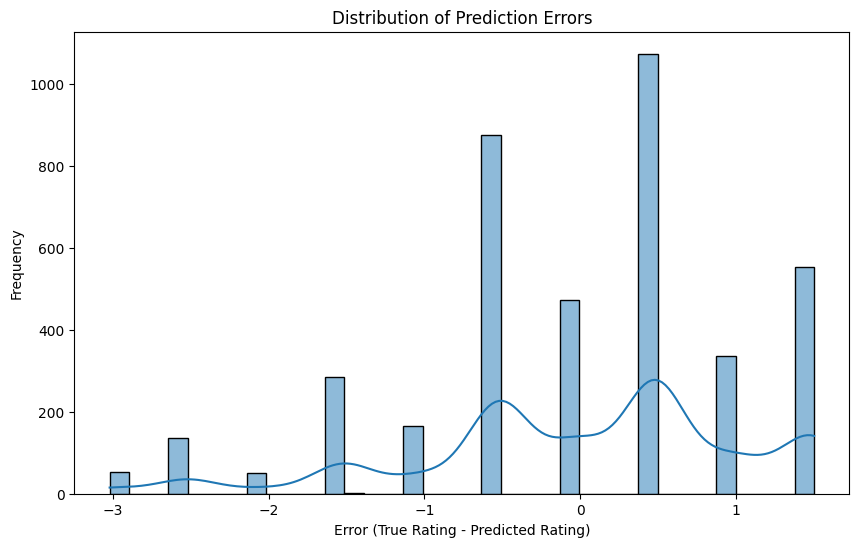

In [25]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use KNNBasic algorithm for User-User Collaborative Filtering
sim_options = {
    'name': 'cosine',
    'user_based': True
}

algo = KNNBasic(sim_options=sim_options)

# Train the algorithm
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

# Evaluate RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Visualizing Prediction Error Distribution
errors = [pred.r_ui - pred.est for pred in predictions]
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (True Rating - Predicted Rating)')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Plotting Precision@K and Recall@K
from collections import defaultdict

def precision_recall_at_k(predictions, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) \
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)

# Average precision and recall
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Average Precision@5: {avg_precision:.4f}')
print(f'Average Recall@5: {avg_recall:.4f}')

Average Precision@5: 0.6110
Average Recall@5: 0.6211
